# Casting Transport Network 

In [1]:
import sys
import json
default = {'scenario': 'base', 'training_folder': '../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.model import stepmodel

import pandas as pd

if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


## Read model

In [2]:
sm = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/networks'.format(scen=argv['scenario']))

epsg: 100%|██████████| 17/17 [00:00<00:00, 121.34it/s]    


# Rail

In [3]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]
rail.preparation_cast_network(dumb_cast=True)

nearest_link: 100%|██████████| 30400/30400 [00:00<00:00, 232158.60it/s]


# Bus

In [4]:
road = sm.copy()
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]
road.links["geometry_links"] = road.links["geometry"]

road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

100100151:151_0: 100%|██████████| 267/267 [00:15<00:00, 16.82it/s]    


# Recombining networks

In [5]:
both = road.copy()
both.links = pd.concat([road.links, rail.links]) 
both.links['length'] = both.links['road_length']
both.analysis_lines(line_columns='all')

# Export

In [6]:
both.to_zippedpickles(argv['training_folder'] + '/model/{scen}/road_model'.format(scen=argv['scenario']))

lines: 100%|██████████| 22/22 [00:01<00:00, 16.98it/s]                    


In [7]:
if not manual:
    end_of_notebook

# Monitoring

Text(0.5, 1.0, "'link_straight_length': 2023, 'straight_length': 1560, 'length': 3050")

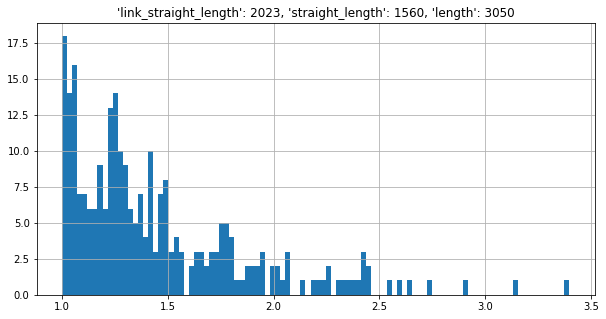

In [9]:
from shapely.geometry import LineString

links = road.links
links['link_straight_length'] = links['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)
road.analysis_lines(sum_columns=['link_straight_length'])
lines = road.lines
lines['length'] = lines['geometry'].apply(lambda g: g.length)
lines['straight_length'] = lines['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

lines['length_ratio'] = lines['length']/lines['link_straight_length']
title = str(
    (lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int).to_dict()
)[1:-1]

ax = lines['length_ratio'].hist(bins=100, figsize=[10, 5])
ax.set_title(title)

# Plot

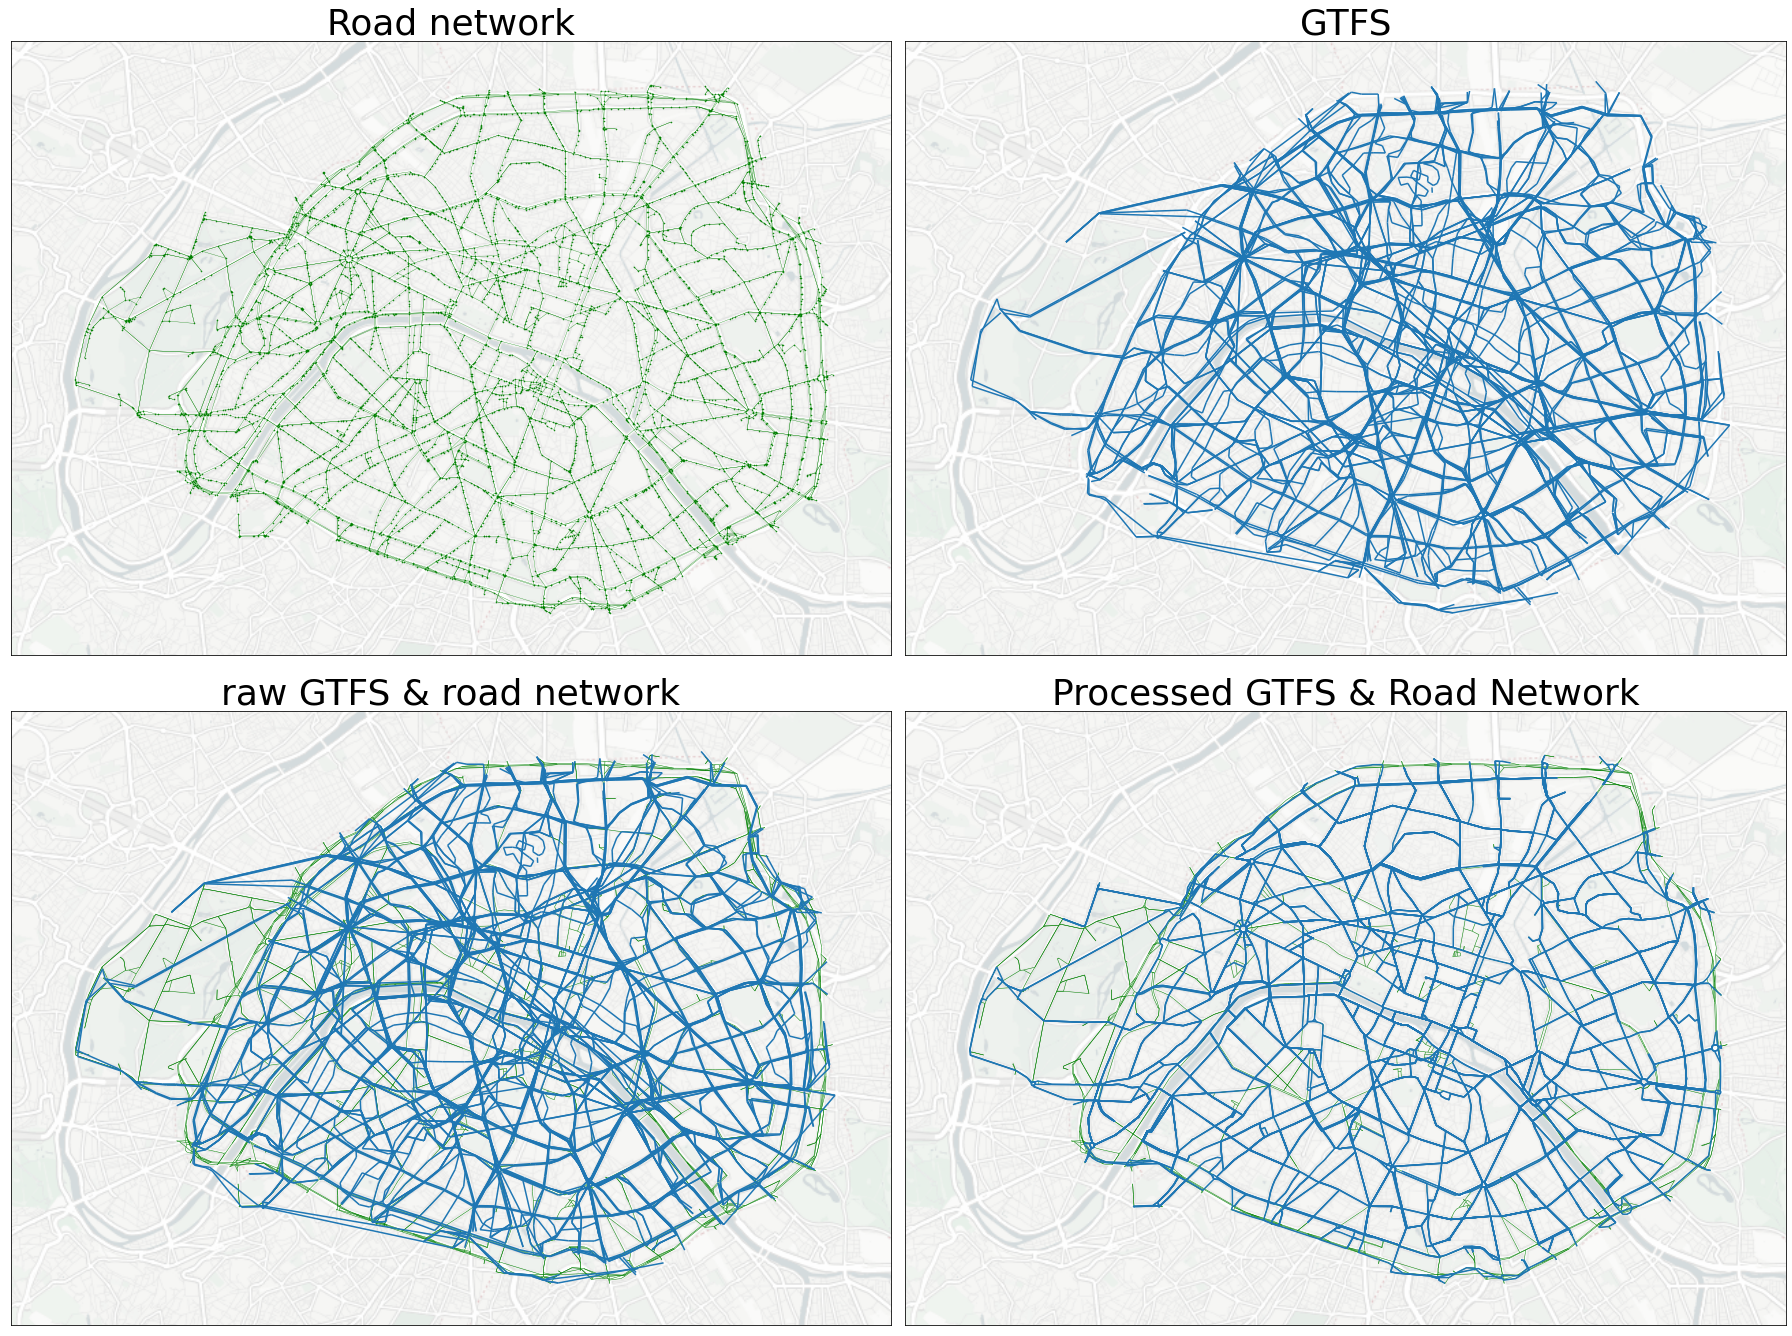

In [10]:
url ='http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'

import matplotlib.pyplot as plt
def plot_networkcaster(raw, processed, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True) 
    buffer = raw.copy()
    buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(500))

    plot = raw.plot(
        'road_nodes', markersize=0.3, color='green',
        ax=raw.plot('road_links', linewidth=0.3, color='green',
                   ax=buffer.plot('zones', alpha=0, ax=ax_array[0][0])
                  ),
        basemap_url=url,title="Road network", fontsize=36
    )
    plot = raw.plot('links', 
                                      ax=buffer.plot('zones', alpha=0, ax=ax_array[0][1]),
        basemap_url=url, title="GTFS", fontsize=36
    )
    plot = raw.plot('links', ax=raw.plot('road_links', color='green', figsize=[16, 9], linewidth=0.5,
                                      ax=buffer.plot('zones', alpha=0, ax=ax_array[1][0])),
        basemap_url=url,title="raw GTFS & road network", fontsize=36
    )
    plot = processed.plot(
        'links', 
        ax=processed.plot('road_links', color='green', figsize=[16, 9], linewidth=0.5,
                     ax=buffer.plot('zones', alpha=0, ax=ax_array[1][1])),
        basemap_url=url,title="Processed GTFS & Road Network", fontsize=36
    )
    return fig

fig = plot_networkcaster(raw=sm, processed=road, url=url)